In [1]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Lambda, Flatten, Reshape, MaxPooling2D
from keras.models import Model
from keras.optimizers import RMSprop
from keras.losses import mean_squared_error, binary_crossentropy, kullback_leibler_divergence
from keras.callbacks import EarlyStopping, TerminateOnNaN, ReduceLROnPlateau
from keras import backend as K
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, scipy
from sklearn.model_selection import train_test_split

from phenom_read_in_data import *

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', 100)

In [3]:
#Getthe data
df_bkg = single_csv_to_df('Documents/Work/PhD/dark_machines/training_files/chan1/background_chan1_7.79.csv')

In [4]:
df_bkg

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,obj2,E2,pt2,eta2,phi2,obj3,E3,pt3,eta3,phi3,obj4,E4,pt4,eta4,phi4,obj5,E5,pt5,eta5,phi5,obj6,E6,pt6,eta6,phi6,obj7,E7,pt7,eta7,phi7,obj8,E8,pt8,eta8,phi8,obj9,E9,pt9,eta9,phi9,obj10,E10,pt10,eta10,phi10,obj11,E11,pt11,eta11,phi11,obj12,E12,pt12,eta12,phi12,obj13,E13,pt13,eta13,phi13,obj14,E14,pt14,eta14,phi14
0,7051621,z_jets,1,390017,0.538031,j,407492,393095,-0.266637,-2.68505,j,633731,283693,1.4419,-0.451286,j,269569,145318,1.22541,2.36482,j,138520,110826,0.688498,2.66743,j,101435,87189.8,0.563578,-2.49198,j,183193,38577.6,-2.23818,-0.295831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,33064349,njets,1,217448,0.663545,j,707690,390901,1.19577,-2.48665,j,165970,162374,-0.073124,0.558267,j,213806,88382.7,1.52776,0.769609,j,190327,63638.8,-1.75736,-1.3494,j,324303,56631.5,2.42978,3.03834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,179392659,njets,1,220238,-1.45891,j,484710,388499,0.669438,2.1595,j,466224,209644,1.43709,-1.48085,j,173345,159358,0.3921,0.722837,b,76508.9,63430.3,0.614221,-0.229462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,185746896,njets,1,237999,1.30691,j,913056,245434,-1.98767,0.978061,j,228497,202999,0.478876,-2.01883,j,153458,146721,-0.259158,-1.87386,j,126963,126389,0.0382953,-2.45528,j,50958.8,41187,0.653297,2.54775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84616096,njets,1,229855,-0.953545,j,302325,294936,0.181659,3.03634,j,360228,251837,-0.8903,0.173217,j,203074,200825,0.149532,2.22357,j,359058,56262.1,2.54026,-0.807584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214180,134098620,njets,1,236904,0.294278,j,647782,316987,-1.33574,0.0408877,j,1.03028e+06,278691,1.98139,-2.63605,j,442513,190614,-1.48267,2.79699,j,353545,120815,1.73419,2.91943,j,34124.5,24021.7,0.867112,-2.37522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214181,15237232,njets,1,263035,-2.15702,j,390920,325540,0.606702,0.269049,j,1.83279e+06,265269,2.62055,2.28375,j,197980,103625,1.25981,-1.96533,j,191427,56799.1,-1.88419,-0.497967,j,54929.9,52948.5,0.25536,0.852269,j,76348.3,43636.1,1.14312,2.3847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214182,20494126,njets,1,344296,-1.45284,j,1.04316e+06,309613,-1.88456,1.17333,j,809841,304875,1.63051,2.00532,b,403629,196592,1.34505,-1.43694,j,400995,83865.8,-2.24571,-3.03264,j,285868,40030.8,-2.65281,-0.773111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214183,85321109,njets,1,227666,0.495691,j,450608,309967,-0.89566,-2.33551,j,216603,214715,0.0388365,0.642919,b,122718,106325,-0.535995,-2.88472,j,132238,85920.4,0.990861,2.96581,j,87140.8,25784.8,1.88563,-0.1567

In [5]:
#If the number of max objects is prime, another column needs to be added to mitigate 

In [6]:
if ((len(df_bkg.columns)-5) % 2 != 0):
    num = str(int(((len(df_bkg.columns) - 5)/5) + 1))
    df_bkg['obj'+num]= -999
    df_bkg['E'+num] = -999
    df_bkg['pt'+num] = -999
    df_bkg['eta'+num] = -999
    df_bkg['phi'+num] = -999

In [7]:
df_bkg

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,obj2,E2,pt2,eta2,phi2,obj3,E3,pt3,eta3,phi3,obj4,E4,pt4,eta4,phi4,obj5,E5,pt5,eta5,phi5,obj6,E6,pt6,eta6,phi6,obj7,E7,pt7,eta7,phi7,obj8,E8,pt8,eta8,phi8,obj9,E9,pt9,eta9,phi9,obj10,E10,pt10,eta10,phi10,obj11,E11,pt11,eta11,phi11,obj12,E12,pt12,eta12,phi12,obj13,E13,pt13,eta13,phi13,obj14,E14,pt14,eta14,phi14
0,7051621,z_jets,1,390017,0.538031,j,407492,393095,-0.266637,-2.68505,j,633731,283693,1.4419,-0.451286,j,269569,145318,1.22541,2.36482,j,138520,110826,0.688498,2.66743,j,101435,87189.8,0.563578,-2.49198,j,183193,38577.6,-2.23818,-0.295831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,33064349,njets,1,217448,0.663545,j,707690,390901,1.19577,-2.48665,j,165970,162374,-0.073124,0.558267,j,213806,88382.7,1.52776,0.769609,j,190327,63638.8,-1.75736,-1.3494,j,324303,56631.5,2.42978,3.03834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,179392659,njets,1,220238,-1.45891,j,484710,388499,0.669438,2.1595,j,466224,209644,1.43709,-1.48085,j,173345,159358,0.3921,0.722837,b,76508.9,63430.3,0.614221,-0.229462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,185746896,njets,1,237999,1.30691,j,913056,245434,-1.98767,0.978061,j,228497,202999,0.478876,-2.01883,j,153458,146721,-0.259158,-1.87386,j,126963,126389,0.0382953,-2.45528,j,50958.8,41187,0.653297,2.54775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84616096,njets,1,229855,-0.953545,j,302325,294936,0.181659,3.03634,j,360228,251837,-0.8903,0.173217,j,203074,200825,0.149532,2.22357,j,359058,56262.1,2.54026,-0.807584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214180,134098620,njets,1,236904,0.294278,j,647782,316987,-1.33574,0.0408877,j,1.03028e+06,278691,1.98139,-2.63605,j,442513,190614,-1.48267,2.79699,j,353545,120815,1.73419,2.91943,j,34124.5,24021.7,0.867112,-2.37522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214181,15237232,njets,1,263035,-2.15702,j,390920,325540,0.606702,0.269049,j,1.83279e+06,265269,2.62055,2.28375,j,197980,103625,1.25981,-1.96533,j,191427,56799.1,-1.88419,-0.497967,j,54929.9,52948.5,0.25536,0.852269,j,76348.3,43636.1,1.14312,2.3847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214182,20494126,njets,1,344296,-1.45284,j,1.04316e+06,309613,-1.88456,1.17333,j,809841,304875,1.63051,2.00532,b,403629,196592,1.34505,-1.43694,j,400995,83865.8,-2.24571,-3.03264,j,285868,40030.8,-2.65281,-0.773111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214183,85321109,njets,1,227666,0.495691,j,450608,309967,-0.89566,-2.33551,j,216603,214715,0.0388365,0.642919,b,122718,106325,-0.535995,-2.88472,j,132238,85920.4,0.990861,2.96581,j,87140.8,25784.8,1.88563,-0.1567

In [8]:
df = df_bkg.fillna(-999)
variables = [entry for entry in df.columns if entry[0] == 'E'] + [entry for entry in df.columns if entry[0:2] == 'pt'] + [entry for entry in df.columns if entry[0:2] == 'et'] + [entry for entry in df.columns if entry[0:2] == 'ph']

In [9]:
#Now we one_hot encode the data to make sure we have a class definition
df = df[['process_ID']+variables]
one_hot = pd.get_dummies(df['process_ID'])
processes = one_hot.columns
df.drop('process_ID', axis = 'columns', inplace = True)
df = pd.concat([df, one_hot], sort = False, axis = 1)

In [10]:
E = [entry for entry in df.columns if entry[0] == 'E']
pt = [entry for entry in df.columns if entry[0:2] == 'pt']
eta = [entry for entry in df.columns if entry[0:2] == 'et']
phi = [entry for entry in df.columns if entry[0:2] == 'ph']

In [11]:
np_E = np.array(df[E])
np_pt = np.array(df[pt])
np_eta = np.array(df[eta])
np_phi = np.array(df[phi])

In [12]:
#We have created a df of our values and some kind of class label
#We should normalize
x = df[variables].values
x_scaled = StandardScaler().fit_transform(x)
df[variables] = x_scaled

x_train, x_test, y_train, y_test = train_test_split(df[variables].values,
                                                    df[processes].values, 
                                                    shuffle = True,
                                                    random_state = 42,
                                                    test_size = 0.1)

In [13]:
#Reshape the data. This will have to be done explicitly until you think of a clever way of doing it
x_train = x_train.reshape((x_train.shape[0], 1, -1, 4))
x_test = x_test.reshape((x_test.shape[0], 1, -1, 4))

In [15]:
#VAE Model
original_dim = x_train.shape[0]
input_shape = x_train.shape[1:]
latent_dim = 4
intermediate_dim = 50
kernel_max_norm = 1000.
act_fun = 'relu'
epsilon_std = 1.
filters = 32
kernel_size = (2, 2)
strides = (1, 1)
pool_size = (1, 1)

In [16]:
K.clear_session()

In [17]:
def sampling(args):
    z_mean, z_log_var=args
    epsilon=tf.random.uniform(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean+K.exp(z_log_var/2)*epsilon
    
#Define some losses
def kl_loss(y_true, y_pred):
    kl_loss = 1 + z_var - K.square(z_mean) - K.exp(z_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    #kl_loss = K.mean(kl_loss)
    return kl_loss

def recon_loss(y_true, y_pred):
    recon_loss = mean_squared_error(K.flatten(y_true), K.flatten(y_pred))
    recon_loss *= shape[0]*shape[1]*shape[2]
    #recon_loss = K.mean(recon_loss)
    return recon_loss
    
def my_vae_loss(y_true, y_pred):
    recon = recon_loss(y_true, y_pred) 
    kl = kl_loss(y_true, y_pred)
    vae_loss = recon + kl
    return vae_loss

    
    #Layers
x_input = Input(shape = input_shape, name = 'Input')
conv_1 = Conv2D(filters = filters, 
                activation = act_fun,
                kernel_size = kernel_size,
                strides = strides, 
                padding = 'same', 
                name = 'conv_1')(x_input)
pool_1 = MaxPooling2D(pool_size = pool_size,
                          strides = 2, 
                          name = 'max_pool')(conv_1)
conv_2 = Conv2D(filters = filters, 
                activation = act_fun, 
                kernel_size = kernel_size, 
                strides = strides, 
                padding = 'same', 
                name = 'conv_2')(pool_1)
#Shape info needed to inform the dense layer in the decoder
flatten = Flatten()(conv_2)#(pool_1)
cnn = Model(x_input, flatten, name = 'cnn')
cnn.summary()

shape = input_shape
    
#Encoding
dense_encoder_1 = Dense(intermediate_dim,
                            activation = act_fun,
                            name = 'dense_encoder_1')(flatten)
dense_encoder_2 = Dense(16,
                            activation = act_fun,
                            name = 'dense_encoder_2')(dense_encoder_1)
z_mean = Dense(latent_dim, name = 'z_mean')(dense_encoder_2)
z_var = Dense(latent_dim, name = 'z_var')(dense_encoder_2)

z = Lambda(sampling, output_shape = (latent_dim, ), name = 'sampling')([z_mean, z_var])

encoder = Model(x_input, [z_mean, z_var, z], name = 'encoder')
encoder.summary()
    
#Decoding
dense_shape = shape[0]*shape[1]*shape[2]
decoder_input = Input(shape = (latent_dim, ), name = 'decoder_input')
dense_decoder_1 = Dense(dense_shape, 
                            activation = act_fun, 
                            name = 'dense_decoder_1')(decoder_input)
reshape = Reshape((shape[0], shape[1], shape[2]))(dense_decoder_1)

deconv_1 = Conv2DTranspose(filters = filters,
                               kernel_size = kernel_size, 
                               activation = act_fun, 
                               strides = strides, 
                               padding = 'same', 
                               name = 'deconv_1')(reshape)
deconv_2 = Conv2DTranspose(filters = 20,
                               kernel_size = kernel_size, 
                               activation = act_fun, 
                               strides = strides, 
                               padding = 'same', 
                               name = 'deconv_2')(deconv_1)

output = Conv2DTranspose(filters = 4, 
                             kernel_size = kernel_size, 
                             #activation = 'sigmoid', 
                             padding = 'same', 
                             strides = strides, 
                             name = 'decoder_output')(deconv_2)

decoder = Model(decoder_input, output, name = 'decoder')
decoder.summary()
    
#Build the VAE model
outputs = decoder(encoder(x_input)[2])
vae = Model(x_input, outputs, name = 'vae')
    
vae.compile(optimizer = 'rmsprop', loss = my_vae_loss, metrics = [kl_loss, recon_loss])
vae.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 1, 14, 4)          0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 1, 14, 32)         544       
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 1, 7, 32)          0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 1, 7, 32)          4128      
_________________________________________________________________
flatten_1 (Flatten)          (None, 224)               0         
Total params: 4,672
Trainable params: 4,672
Non-trainable params: 0
_________________________________________________________________
Model: "encoder"
__________________________________________________________________________________________________
Layer (type

In [18]:
#Fit the model
epochs = 100
batch_size = 1000

parameters = {
             'intermediate_dim' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
             'act_fun' : ['relu', 'softmax', 'sigmoid'], 
             'filters' : [16, 32, 64, 128, 256], 
             'kernel_size' : [(1,1), (2,2), (3,3)], 
             'strides' : [(1,1), (2,2), (3,3)]
             }

#vae = make_model()
#vae = KerasClassifier(build_fn=make_model, epochs = epochs, batch_size = batch_size)
#acc_scorer = make_scorer(accuracy_score)
#grid_obj = GridSearchCV(estimator=vae, param_grid=parameters, scoring=acc_scorer)
#grid_obj = grid_obj.fit(x_train, x_train)

#Set the clf to the best combination of parameters
#vae = grid_obj.best_estimator_

history = vae.fit(x = x_train,
                  y = x_train,
                  validation_data = (x_train, x_train),
                  epochs = epochs,
                  batch_size = batch_size,
                  verbose = 2)

vae.save('cnn-vae_model.h5')

Train on 192766 samples, validate on 192766 samples
Epoch 1/100
 - 7s - loss: 30045801.5925 - kl_loss: 30044286.0000 - recon_loss: 1494.3900 - val_loss: 1108168163691.0469 - val_kl_loss: 1087031214080.0000 - val_recon_loss: 21111367680.0000
Epoch 2/100
 - 7s - loss: 405431.3307 - kl_loss: 381184.5000 - recon_loss: 24216.4473 - val_loss: 43.4400 - val_kl_loss: 1.9092 - val_recon_loss: 41.5159
Epoch 3/100
 - 7s - loss: 42.6211 - kl_loss: 1.8462 - recon_loss: 40.7541 - val_loss: 41.0928 - val_kl_loss: 1.7312 - val_recon_loss: 39.3475
Epoch 4/100
 - 8s - loss: 40.0530 - kl_loss: 1.6781 - recon_loss: 38.3602 - val_loss: 38.8283 - val_kl_loss: 1.7372 - val_recon_loss: 37.0770
Epoch 5/100
 - 7s - loss: 37.9960 - kl_loss: 1.6877 - recon_loss: 36.2909 - val_loss: 36.9049 - val_kl_loss: 1.6001 - val_recon_loss: 35.2912
Epoch 6/100
 - 7s - loss: 36.6820 - kl_loss: 1.7337 - recon_loss: 34.9364 - val_loss: 35.6078 - val_kl_loss: 1.6655 - val_recon_loss: 33.9291
Epoch 7/100
 - 7s - loss: 35.3207 - k

Epoch 58/100
 - 7s - loss: 21.9597 - kl_loss: 2.1468 - recon_loss: 19.8073 - val_loss: 21.3115 - val_kl_loss: 2.2177 - val_recon_loss: 19.0883
Epoch 59/100
 - 7s - loss: 21.5092 - kl_loss: 2.1861 - recon_loss: 19.3174 - val_loss: 21.1001 - val_kl_loss: 2.1787 - val_recon_loss: 18.9161
Epoch 60/100
 - 7s - loss: 21.8690 - kl_loss: 2.1802 - recon_loss: 19.6820 - val_loss: 20.8501 - val_kl_loss: 2.2774 - val_recon_loss: 18.5677
Epoch 61/100
 - 7s - loss: 21.5478 - kl_loss: 2.2793 - recon_loss: 19.2632 - val_loss: 20.8917 - val_kl_loss: 2.1522 - val_recon_loss: 18.7343
Epoch 62/100
 - 7s - loss: 21.4980 - kl_loss: 2.2138 - recon_loss: 20.0936 - val_loss: 21.9239 - val_kl_loss: 2.3945 - val_recon_loss: 19.5241
Epoch 63/100
 - 7s - loss: 21.2298 - kl_loss: 2.3034 - recon_loss: 18.9200 - val_loss: 20.4753 - val_kl_loss: 2.3349 - val_recon_loss: 18.1358
Epoch 64/100
 - 7s - loss: 21.0024 - kl_loss: 2.2563 - recon_loss: 18.7413 - val_loss: 20.1042 - val_kl_loss: 2.3461 - val_recon_loss: 17.7543

In [19]:
y_pred = vae.predict(x_test.reshape(x_test.shape[0], 1, -1, 4))
#ravel returns flattened array

In [20]:
x_train_reshape = x_train.reshape(x_train.shape[0], -1)

In [21]:
x_train_df = pd.DataFrame(x_train_reshape, columns = variables)

In [22]:
x_train_E = np.array(x_train_df[E])
x_train_pt = np.array(x_train_df[pt])
x_train_phi = np.array(x_train_df[phi])
x_train_eta = np.array(x_train_df[eta])

In [23]:
y_pred_reshape = y_pred.reshape(y_pred.shape[0], -1)

In [24]:
y_pred_df = pd.DataFrame(y_pred_reshape, columns = variables)

In [25]:
y_pred_E = np.array(y_pred_df[E])
y_pred_pt = np.array(y_pred_df[pt])
y_pred_phi = np.array(y_pred_df[phi])
y_pred_eta = np.array(y_pred_df[eta])

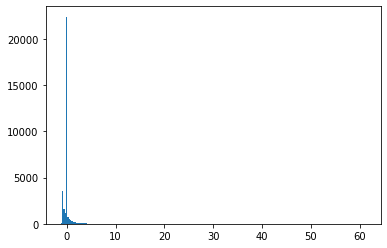

In [26]:
n, bins, patches = plt.hist(x_train_E.flatten()[:100000], 1000)

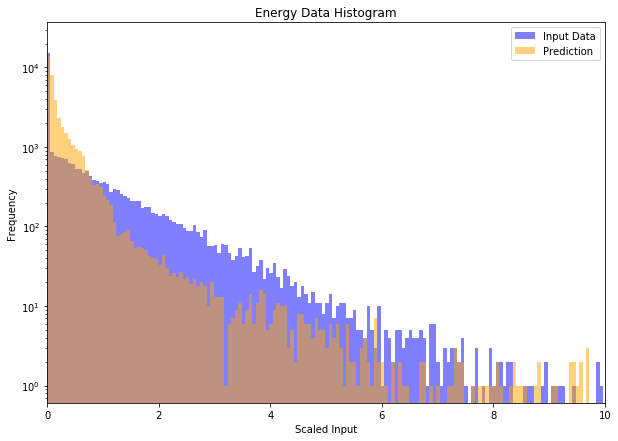

In [27]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input')
plt.ylabel('Frequency')
plt.title('Energy Data Histogram')
plt.hist(x_train_E.flatten()[:100000], bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_E.flatten()[:100000], bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

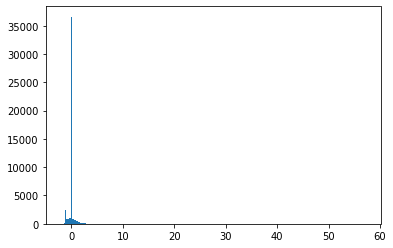

In [28]:
n, bins, patches = plt.hist(x_train_pt.flatten()[:100000], 1000)

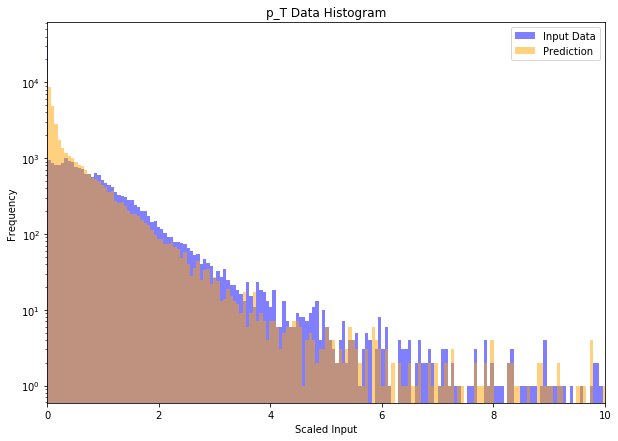

In [29]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input')
plt.ylabel('Frequency')
plt.title('p_T Data Histogram')
plt.hist(x_train_pt.flatten()[:100000], bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_pt.flatten()[:100000], bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

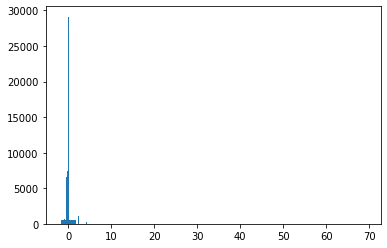

In [30]:
n, bins, patches = plt.hist(x_train_phi.flatten()[:100000], 1000)

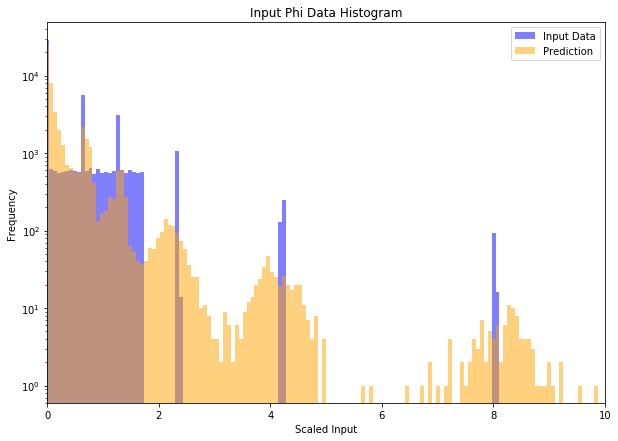

In [31]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input')
plt.ylabel('Frequency')
plt.title('Input Phi Data Histogram')
plt.hist(x_train_phi.flatten()[:100000], bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_phi.flatten()[:100000], bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

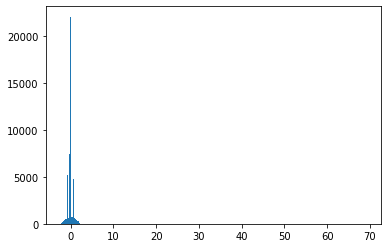

In [32]:
n, bins, patches = plt.hist(x_train_eta.flatten()[:100000], 1000)

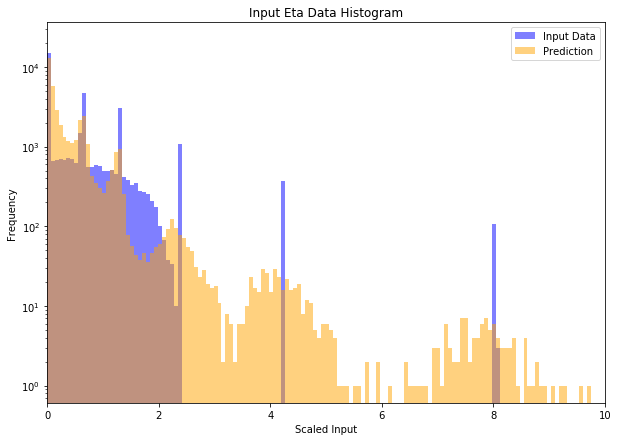

In [33]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input')
plt.ylabel('Frequency')
plt.title('Input Eta Data Histogram')
plt.hist(x_train_eta.flatten()[:100000], bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_eta.flatten()[:100000], bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

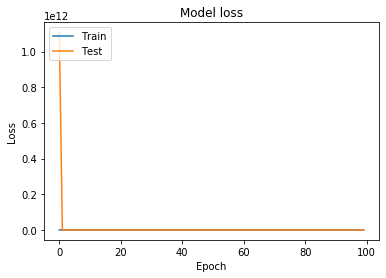

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [35]:
vae.metrics_names

['loss', 'kl_loss', 'recon_loss']

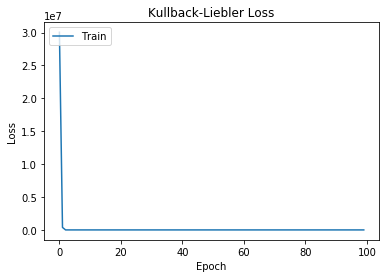

In [36]:
plt.plot(history.history['kl_loss'])
plt.title('Kullback-Liebler Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

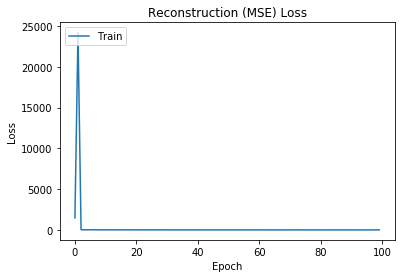

In [37]:
plt.plot(history.history['recon_loss'])
plt.title('Reconstruction (MSE) Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [38]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [39]:
#We are going to try plotting our roc curve. First we should get a set of loss values and make our binary vecs

In [40]:
df_glu_1400 = single_csv_to_df('Documents/Work/PhD/dark_machines/training_files/chan1/signals/glgl1400_neutralino1100_chan1.csv')
df_glu_1400

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,obj2,E2,pt2,eta2,phi2,obj3,E3,pt3,eta3,phi3,obj4,E4,pt4,eta4,phi4,obj5,E5,pt5,eta5,phi5,obj6,E6,pt6,eta6,phi6,obj7,E7,pt7,eta7,phi7,obj8,E8,pt8,eta8,phi8,obj9,E9,pt9,eta9,phi9,obj10,E10,pt10,eta10,phi10,obj11,E11,pt11,eta11,phi11,obj12,E12,pt12,eta12,phi12,obj13,E13,pt13,eta13,phi13
0,90934,glgl1400_neutralino1100,8.17901e-07,966678,1.88616,j,1.11905e+06,1.09924e+06,0.150071,-1.34083,j,559871,165567,-1.88859,1.47369,j,226151,165330,-0.802848,2.94516,j,197519,154998,-0.720248,-0.0941964,j,133609,71234.1,1.23674,-0.667677,j,33148.6,24613.8,-0.795032,2.00452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,90934,glgl1400_neutralino1100,8.17901e-07,272431,-0.253703,j,275612,245021,-0.469702,-2.83812,j,166684,143305,0.531173,2.26821,j,205771,103965,-1.30103,-0.295798,j,129144,81242.1,1.02916,0.971936,j,302875,75746.9,2.06247,2.73778,j,131327,67613.4,-1.2765,-1.23786,j,1.82257e+06,38105.4,-4.56068,2.93394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,90934,glgl1400_neutralino1100,8.17901e-07,326833,0.49523,j,563988,312717,1.18657,-1.43681,j,1.34499e+06,250037,-2.36676,2.86416,j,184328,133523,-0.826793,1.13601,j,96540.3,95206.5,-0.0201483,-2.08715,j,168074,91527.5,-1.21047,2.77205,j,57918.2,53202.6,-0.414333,2.65978,j,77619,40325.2,1.26557,-0.140817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,90934,glgl1400_neutralino1100,8.17901e-07,393198,0.551451,b,364748,274872,-0.761967,2.96886,j,636767,256438,1.55925,-2.528,b,186686,129489,0.906826,-0.737084,j,240253,63869.8,1.99805,0.277679,j,48670.2,24901.7,-1.28639,-2.24453,j,26835.1,24075.5,0.45788,-1.43184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,90934,glgl1400_neutralino1100,8.17901e-07,264860,0.141786,j,359307,342962,0.222528,-2.76879,j,1.03187e+06,201249,2.31779,0.180633,j,133718,103956,-0.715326,2.11942,j,90369.9,72605,-0.676961,-2.51046,j,29353.3,28919.1,0.127996,2.61299,j,27749.1,26424.4,-0.288125,-1.97123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,90934,glgl1400_neutralino1100,8.17901e-07,358586,-2.68716,j,544458,319749,-1.11093,0.350326,j,141426,133030,-0.339183,0.288143,j,131650,128141,-0.211974,3.04308,j,101701,51492.9,1.29381,0.116708,j,819695,47059.3,-3.54982,-1.41129,j,76579.2,29094.8,-1.62119,2.88376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4092,90934,glgl1400_neutralino1100,8.17901e-07,465893,-3.08648,j,304548,296864,0.179741,-0.647328,j,181607,170330,-0.361503,0.820824,j,131605,126303,0.215301,0.0479811,j,149316,69157.4,1.40403,1.9427,j,67379.9,43891.9,0.982377,0.697756,j,36061.3,28766.5,0.696602,-2.50107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4093,90934,glgl1400_neutralino1100,8.17901e-07,785737,-2.1627,j,694694,623764,-0.408878,1.48107,j,451083,415452,0.380902,0.699667,j,387672,255939,-0.970173,-0.776873,j,163110,147494,-0.399345,2.53661,j,254535,102326,-1.5605,-2.45995,j,86432.7,84916.4,-0.111943,0.0639032,j,71494.7,67961.2,0.288945,-1.56212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4094,90934,glgl1400_neutralin

In [41]:
if (len(df_glu_1400)-5)%2 != 0: 
    num = str(int(((len(df_glu_1400.columns) - 5)/5) + 1))
    df_glu_1400['obj'+num]= -999
    df_glu_1400['E'+num] = -999
    df_glu_1400['pt'+num] = -999
    df_glu_1400['eta'+num] = -999
    df_glu_1400['phi'+num] = -999

In [42]:
df_glu_1400

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,obj2,E2,pt2,eta2,phi2,obj3,E3,pt3,eta3,phi3,obj4,E4,pt4,eta4,phi4,obj5,E5,pt5,eta5,phi5,obj6,E6,pt6,eta6,phi6,obj7,E7,pt7,eta7,phi7,obj8,E8,pt8,eta8,phi8,obj9,E9,pt9,eta9,phi9,obj10,E10,pt10,eta10,phi10,obj11,E11,pt11,eta11,phi11,obj12,E12,pt12,eta12,phi12,obj13,E13,pt13,eta13,phi13,obj14,E14,pt14,eta14,phi14
0,90934,glgl1400_neutralino1100,8.17901e-07,966678,1.88616,j,1.11905e+06,1.09924e+06,0.150071,-1.34083,j,559871,165567,-1.88859,1.47369,j,226151,165330,-0.802848,2.94516,j,197519,154998,-0.720248,-0.0941964,j,133609,71234.1,1.23674,-0.667677,j,33148.6,24613.8,-0.795032,2.00452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,-999,-999,-999,-999
1,90934,glgl1400_neutralino1100,8.17901e-07,272431,-0.253703,j,275612,245021,-0.469702,-2.83812,j,166684,143305,0.531173,2.26821,j,205771,103965,-1.30103,-0.295798,j,129144,81242.1,1.02916,0.971936,j,302875,75746.9,2.06247,2.73778,j,131327,67613.4,-1.2765,-1.23786,j,1.82257e+06,38105.4,-4.56068,2.93394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,-999,-999,-999,-999
2,90934,glgl1400_neutralino1100,8.17901e-07,326833,0.49523,j,563988,312717,1.18657,-1.43681,j,1.34499e+06,250037,-2.36676,2.86416,j,184328,133523,-0.826793,1.13601,j,96540.3,95206.5,-0.0201483,-2.08715,j,168074,91527.5,-1.21047,2.77205,j,57918.2,53202.6,-0.414333,2.65978,j,77619,40325.2,1.26557,-0.140817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,-999,-999,-999,-999
3,90934,glgl1400_neutralino1100,8.17901e-07,393198,0.551451,b,364748,274872,-0.761967,2.96886,j,636767,256438,1.55925,-2.528,b,186686,129489,0.906826,-0.737084,j,240253,63869.8,1.99805,0.277679,j,48670.2,24901.7,-1.28639,-2.24453,j,26835.1,24075.5,0.45788,-1.43184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,-999,-999,-999,-999
4,90934,glgl1400_neutralino1100,8.17901e-07,264860,0.141786,j,359307,342962,0.222528,-2.76879,j,1.03187e+06,201249,2.31779,0.180633,j,133718,103956,-0.715326,2.11942,j,90369.9,72605,-0.676961,-2.51046,j,29353.3,28919.1,0.127996,2.61299,j,27749.1,26424.4,-0.288125,-1.97123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,90934,glgl1400_neutralino1100,8.17901e-07,358586,-2.68716,j,544458,319749,-1.11093,0.350326,j,141426,133030,-0.339183,0.288143,j,131650,128141,-0.211974,3.04308,j,101701,51492.9,1.29381,0.116708,j,819695,47059.3,-3.54982,-1.41129,j,76579.2,29094.8,-1.62119,2.88376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,-999,-999,-999,-999
4092,90934,glgl1400_neutralino1100,8.17901e-07,465893,-3.08648,j,304548,296864,0.179741,-0.647328,j,181607,170330,-0.361503,0.820824,j,131605,126303,0.215301,0.0479811,j,149316,69157.4,1.40403,1.9427,j,67379.9,43891.9,0.982377,0.697756,j,36061.3,28766.5,0.696602,-2.50107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,-999,-999,-999,-999
4093,90934,glgl1400_neutralino1100,8.17901e-07,785737,-2.1627,j,694694,623764,-0.408878,1.48107,j,451083,415452,0.380902,0.699667,j,387672,255939,-0.970173,-0.776873,j,163110,147494,-0.399345,2.53661,j,254535,102326,-1.5605,-2.45995,j

In [43]:
df_glu_1400 = df_glu_1400.fillna(-999)
variables = [entry for entry in df_glu_1400.columns if entry[0] == 'E'] + [entry for entry in df_glu_1400.columns if entry[0:2] == 'pt'] + [entry for entry in df_glu_1400.columns if entry[0:2] == 'et'] + [entry for entry in df_glu_1400.columns if entry[0:2] == 'ph']

In [44]:
df_glu_1400 = df_glu_1400[['process_ID']+variables]
one_hot = pd.get_dummies(df_glu_1400['process_ID'])
processes = one_hot.columns
df_glu_1400.drop('process_ID', axis = 'columns', inplace = True)
df_glu_1400 = pd.concat([df_glu_1400, one_hot], sort = False, axis = 1)

In [45]:
E = [entry for entry in df_glu_1400.columns if entry[0] == 'E']
pt = [entry for entry in df_glu_1400.columns if entry[0:2] == 'pt']
eta = [entry for entry in df_glu_1400.columns if entry[0:2] == 'et']
phi = [entry for entry in df_glu_1400.columns if entry[0:2] == 'ph']

In [46]:
x_glu_1400 = df_glu_1400[variables].values
x_glu_1400_scaled = StandardScaler().fit_transform(x_glu_1400)
df_glu_1400[variables] = x_glu_1400_scaled

x_train_glu_1400, x_test_glu_1400, y_train_glu_1400, y_test_glu_1400 = train_test_split(df_glu_1400[variables].values,
                                                                                        df_glu_1400[processes].values, 
                                                                                        shuffle = True,
                                                                                        random_state = 42,
                                                                                        test_size = 0.1)

In [47]:
x_train_glu_1400 = x_train_glu_1400.reshape((x_train_glu_1400.shape[0], 1, -1, 4))
x_test_glu_1400 = x_test_glu_1400.reshape((x_test_glu_1400.shape[0], 1, -1, 4))

In [48]:
y_pred_sm = [vae.predict(x_test.reshape(x_test.shape[0], 1, 1, -1, 4)[i]) for i in range(x_test.shape[0])]

In [49]:
y_pred_bsm = [vae.predict(x_test_glu_1400.reshape(x_test_glu_1400.shape[0], 1, 1, -1, 4)[i]) for i in range(x_test_glu_1400.shape[0])]

In [50]:
y_pred_total = np.append(y_pred_sm, y_pred_bsm)

In [51]:
y_pred_sm = np.array(y_pred_sm)
y_pred_bsm = np.array(y_pred_bsm)
x_test_flatten = np.array(x_test)
x_test_glu_1400_flatten = np.array(x_test_glu_1400)

In [52]:
y_pred_sm = y_pred_sm.flatten()
y_pred_bsm = y_pred_bsm.flatten()
x_test_flatten = x_test_flatten.flatten()
x_test_glu_1400_flatten = x_test_glu_1400_flatten.flatten()

In [53]:
y_true = np.append(np.zeros(len(y_pred_sm)), np.ones(len(y_pred_bsm)))

In [54]:
y_pred_total_norm = y_pred_total/np.linalg.norm(y_pred_total)

In [55]:
y_pred_total_norm

array([ 1.8401402e-05, -3.7564198e-05, -1.5123990e-04, ...,
       -3.8752354e-05, -2.0062414e-05, -3.4555156e-05], dtype=float32)

In [56]:
fpr, tpr, _ = roc_curve(y_true, y_pred_total_norm)

In [57]:
roc_auc = auc(fpr, tpr)

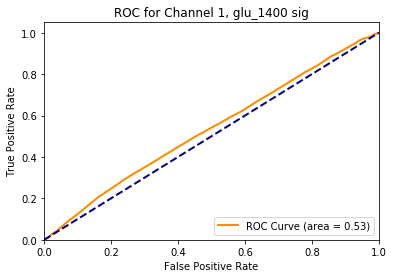

In [58]:
lw = 2
plt.plot(fpr, tpr, color = 'darkorange', lw = lw, 
         label = 'ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0., 1.])
plt.ylim([0., 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Channel 1, glu_1400 sig')
plt.legend(loc = 'lower right')
plt.show()

In [60]:
from fpr_tpr_calc import *

In [61]:
path1 = 'Documents/Work/PhD/dark_machines/training_files/chan1/signals/glgl1400_neutralino1100_chan1.csv'
fpr1, tpr1 = fpr_tpr_calc(path1, vae, x_test, df_bkg)

In [62]:
path2 = 'Documents/Work/PhD/dark_machines/training_files/chan1/signals/glgl1600_neutralino800_chan1.csv'
path3 = 'Documents/Work/PhD/dark_machines/training_files/chan1/signals/stlp_st1000_chan1.csv'
path4 = 'Documents/Work/PhD/dark_machines/training_files/chan1/signals/monotop_200_A_chan1.csv'
path5 = 'Documents/Work/PhD/dark_machines/training_files/chan1/signals/stop2b1000_neutralino300_chan1.csv'
path6 = 'Documents/Work/PhD/dark_machines/training_files/chan1/signals/sqsq_sq1800_neut800_chan1.csv'
path7 = 'Documents/Work/PhD/dark_machines/training_files/chan1/signals/sqsq1_sq1400_neut800_chan1.csv'
path8 = 'Documents/Work/PhD/dark_machines/training_files/chan1/signals/monojet_Zp2000.0_DM_50.0_chan1.csv'

In [63]:
fpr2, tpr2 = fpr_tpr_calc(path2, vae, x_test, df_bkg)
fpr3, tpr3 = fpr_tpr_calc(path3, vae, x_test, df_bkg)
fpr4, tpr4 = fpr_tpr_calc(path4, vae, x_test, df_bkg)
fpr5, tpr5 = fpr_tpr_calc(path5, vae, x_test, df_bkg)
fpr6, tpr6 = fpr_tpr_calc(path6, vae, x_test, df_bkg)
fpr7, tpr7 = fpr_tpr_calc(path7, vae, x_test, df_bkg)
fpr8, tpr8 = fpr_tpr_calc(path8, vae, x_test, df_bkg)

In [64]:
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'lime']

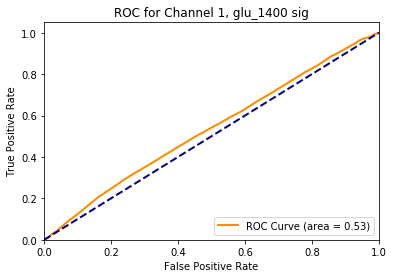

In [65]:
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color = 'darkorange', lw = lw, 
         label = 'ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0., 1.])
plt.ylim([0., 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Channel 1, glu_1400 sig')
plt.legend(loc = 'lower right')
plt.show()

In [66]:
fprs = [fpr1, fpr2, fpr3, fpr4, fpr5, fpr6, fpr7, fpr8]
tprs = [tpr1, tpr2, tpr3, tpr4, tpr5, tpr6, tpr7, tpr8]
signals = ['glgl1400_neutralino1100', 
           'glgl1600_neutralino800', 
           'stlp_st1000',
           'monotop_200',
           'stop2b1000', 
           'sqsq_sq1800_neut800', 
           'sqsq1_sq1400', 
           'monojet_Zp2000.0_DM_50.0']

/home/joe/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


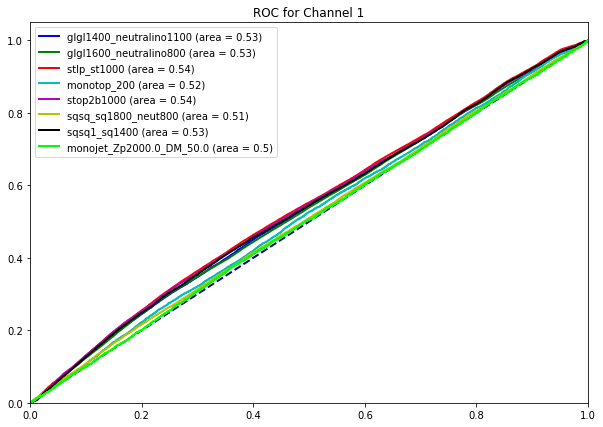

In [67]:
lw = 2
plt.figure(figsize = (10, 7))
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0., 1.])
plt.ylim([0, 1.05])
plt.title('ROC for Channel 1')
for fpr, tpr, sig, col in zip(fprs, tprs, signals, colours):
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color = col, lw = lw, 
             label = '{} (area = {})'.format(sig, round(roc_auc, 2)))
plt.legend()
plt.show()

In [68]:
df_temp = single_csv_to_df(path1)
df_temp

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,obj2,E2,pt2,eta2,phi2,obj3,E3,pt3,eta3,phi3,obj4,E4,pt4,eta4,phi4,obj5,E5,pt5,eta5,phi5,obj6,E6,pt6,eta6,phi6,obj7,E7,pt7,eta7,phi7,obj8,E8,pt8,eta8,phi8,obj9,E9,pt9,eta9,phi9,obj10,E10,pt10,eta10,phi10,obj11,E11,pt11,eta11,phi11,obj12,E12,pt12,eta12,phi12,obj13,E13,pt13,eta13,phi13
0,90934,glgl1400_neutralino1100,8.17901e-07,966678,1.88616,j,1.11905e+06,1.09924e+06,0.150071,-1.34083,j,559871,165567,-1.88859,1.47369,j,226151,165330,-0.802848,2.94516,j,197519,154998,-0.720248,-0.0941964,j,133609,71234.1,1.23674,-0.667677,j,33148.6,24613.8,-0.795032,2.00452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,90934,glgl1400_neutralino1100,8.17901e-07,272431,-0.253703,j,275612,245021,-0.469702,-2.83812,j,166684,143305,0.531173,2.26821,j,205771,103965,-1.30103,-0.295798,j,129144,81242.1,1.02916,0.971936,j,302875,75746.9,2.06247,2.73778,j,131327,67613.4,-1.2765,-1.23786,j,1.82257e+06,38105.4,-4.56068,2.93394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,90934,glgl1400_neutralino1100,8.17901e-07,326833,0.49523,j,563988,312717,1.18657,-1.43681,j,1.34499e+06,250037,-2.36676,2.86416,j,184328,133523,-0.826793,1.13601,j,96540.3,95206.5,-0.0201483,-2.08715,j,168074,91527.5,-1.21047,2.77205,j,57918.2,53202.6,-0.414333,2.65978,j,77619,40325.2,1.26557,-0.140817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,90934,glgl1400_neutralino1100,8.17901e-07,393198,0.551451,b,364748,274872,-0.761967,2.96886,j,636767,256438,1.55925,-2.528,b,186686,129489,0.906826,-0.737084,j,240253,63869.8,1.99805,0.277679,j,48670.2,24901.7,-1.28639,-2.24453,j,26835.1,24075.5,0.45788,-1.43184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,90934,glgl1400_neutralino1100,8.17901e-07,264860,0.141786,j,359307,342962,0.222528,-2.76879,j,1.03187e+06,201249,2.31779,0.180633,j,133718,103956,-0.715326,2.11942,j,90369.9,72605,-0.676961,-2.51046,j,29353.3,28919.1,0.127996,2.61299,j,27749.1,26424.4,-0.288125,-1.97123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,90934,glgl1400_neutralino1100,8.17901e-07,358586,-2.68716,j,544458,319749,-1.11093,0.350326,j,141426,133030,-0.339183,0.288143,j,131650,128141,-0.211974,3.04308,j,101701,51492.9,1.29381,0.116708,j,819695,47059.3,-3.54982,-1.41129,j,76579.2,29094.8,-1.62119,2.88376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4092,90934,glgl1400_neutralino1100,8.17901e-07,465893,-3.08648,j,304548,296864,0.179741,-0.647328,j,181607,170330,-0.361503,0.820824,j,131605,126303,0.215301,0.0479811,j,149316,69157.4,1.40403,1.9427,j,67379.9,43891.9,0.982377,0.697756,j,36061.3,28766.5,0.696602,-2.50107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4093,90934,glgl1400_neutralino1100,8.17901e-07,785737,-2.1627,j,694694,623764,-0.408878,1.48107,j,451083,415452,0.380902,0.699667,j,387672,255939,-0.970173,-0.776873,j,163110,147494,-0.399345,2.53661,j,254535,102326,-1.5605,-2.45995,j,86432.7,84916.4,-0.111943,0.0639032,j,71494.7,67961.2,0.288945,-1.56212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4094,90934,glgl1400_neutralin